# Contextual Bandits Toy Problem

This notebook demonstrates usage of the SpaceBandits package for deep contextual bandits problems.

## Toy Problem
Contextual bandits models are difficult to validate due to the nature of the problems they try to solve. The best way to confirm a model converges in practice is to use a toy problem where the reward for all possible action is known to the evaluator.<br><br>
This notebook has a very simple toy problem. We are dealing with a group of customers. We have two features: Age, and ARPU (some measure of that customer's spend at our company.) There are two groups of customers, which can be seen in the scatterplot below.<br><br>
Our company offers three promotions: the first is best for one group of customers, while the third is best for the other group. The second promotion is not optimal for either customer group. As in most real-life situations, a significant number of customers will not make purchases. Contextual bandits models handle this behavior gracefully, as they model reward generation as a stochastic process.<br><br> 
The following functions spin up our toy data.

In [1]:
import numpy as np
import pandas as pd
from random import random, randint
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from space_bandits.toy_problem import get_cust_reward, get_customer, get_rewards
##Generate Data

## Visualizing the Groups
We can see in our simple toy problem the two groups are visually separable in the feature space.

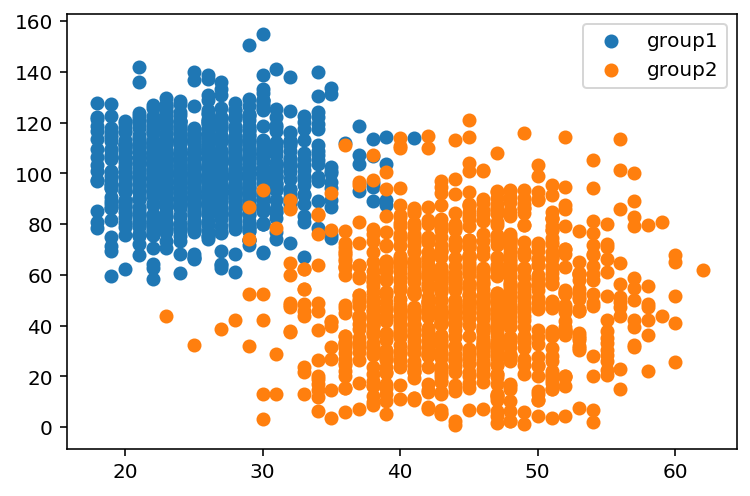

In [2]:
group1 = [get_customer(ctype=1)[1] for x in range(1000)]
group2 = [get_customer(ctype=2)[1] for x in range(1000)]
plt.scatter([x[0] for x in group1], [x[1] for x in group1], label='group1');
plt.scatter([x[0] for x in group2], [x[1] for x in group2], label='group2');
plt.legend();

## Sanity Check: Expected Rewards
To make sure the data-generating functions work well, I randomly sample from both groups of customers and get the average reward from each. This helps me confirm which offers are best for which group.

In [3]:
customers = [get_customer(ctype=1) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (100000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=2) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
rewards.mean(axis=0)
print('group 2 expected rewards: (100000 samples)', rewards.mean(axis=0))

group 1 expected rewards: (100000 samples) [9.002   2.45125 1.961  ]
group 2 expected rewards: (100000 samples) [ 2.5107  2.465  20.109 ]


## The Model's Task
The contextual bandit model does not know that there are two customer populations. It has to discover these distributions and characterize their spending behavior simultaneously. This is the nature of the contextual bandits problem, and it's what makes the problem so hard.<br><br>
On a first pass, we'll use a Bayesian linear regression model that directly maps the features to an expected reward via linear coefficients. We'll use "online" learning for this example, meaning the model makes a decision, observes a reward, and repeats.

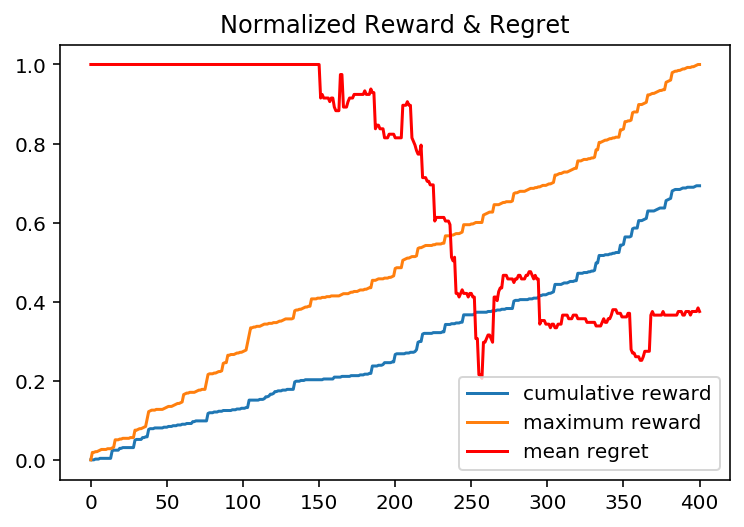

In [4]:
from space_bandits import LinearBandits

num_actions = 3
num_features = 2

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)
optimal_choices = [None, 0, 2]

def iterate_model(model, optimal_choices, steps, records=None, plot_frequency=250, avg_length=150):
    """Goes through online learning simulation with model."""
    #these will track values for plotting
    if records is None:
        records = dict()
        records['timesteps'] = []
        records['c_reward'] = []
        records['cumulative_reward'] = 0
        records['m_reward'] = []
        records['maximum_reward'] = 0
        records['regret_record'] = []
        records['avg_regret'] = []
        start = 0
    else:
        start = records['timesteps'][-1]
    for i in range(start, start+steps):
        records['timesteps'].append(i)
        #generate a customer
        cust = get_customer()
        #generate customer decisions based on group
        reward_vec = get_rewards(cust)
        #prepare features for model
        context = np.array([cust[1]])
        best_choice = optimal_choices[cust[0]]
        #get reward for 'best' choice
        mx = reward_vec[best_choice]
        records['maximum_reward'] += mx
        records['m_reward'].append(records['maximum_reward'])
        action = model.action(context)
        #get reward for the action chosen by model
        reward = reward_vec[action]
        #regret is the opportunity cost of not choosing the optimal promotion
        regret = mx - reward
        records['regret_record'].append(regret)
        records['cumulative_reward'] += reward
        records['c_reward'].append(records['cumulative_reward'])
        model.update(context, action, reward)
        #plot occasionally
        if i <= avg_length:
            if i < avg_length:
                moving_avg=0
            else:
                moving_avg = np.array(records['regret_record']).mean()
            if i == avg_length:
                records['avg_regret'] = [moving_avg] * avg_length
        else:
            moving_avg = sum(records['regret_record'][-avg_length:])/avg_length
        records['avg_regret'].append(moving_avg)
        if i % plot_frequency == 0 and i > 0:
            c_rewardplt = np.array(records['c_reward'])/max(records['m_reward'])
            m_rewardplt = np.array(records['m_reward'])/max(records['m_reward'])
            regretplt = np.array(records['avg_regret'])/max(records['avg_regret'])
            plt.plot(records['timesteps'], c_rewardplt, label='cumulative reward')
            plt.plot(records['timesteps'], m_rewardplt, label='maximum reward')
            plt.plot(records['timesteps'], regretplt, color='red', label='mean regret')
            plt.title('Normalized Reward & Regret')
            plt.legend()
            plt.show()
    return records
            
records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)

## Optimizing
We see high regret early on, but after the model optimizes, regret (maximum reward minus earned reward) drops significantly.

## Saving/Loading
We can save and load models freely and continue learning after re-loading (as is done below). This is important functionality for an online model.

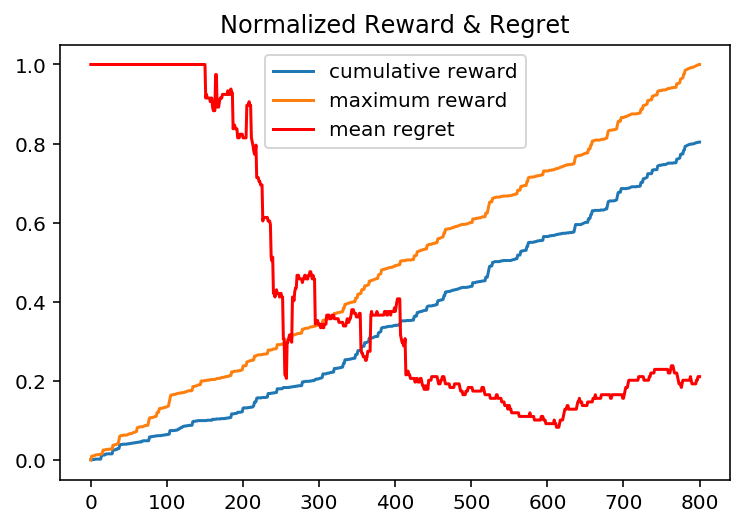

In [5]:
#test linear model saving/loading
from space_bandits import load_model
linear_model.save('test_path.pkl')
linear_model = load_model('test_path.pkl')

#continue training

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=800, records=records)

## Visualizing the Decision Boundary
After converging, the model will recommend a different offer depending on where a given customer appears in the feature space. We can visualize this as a "decision boundary."

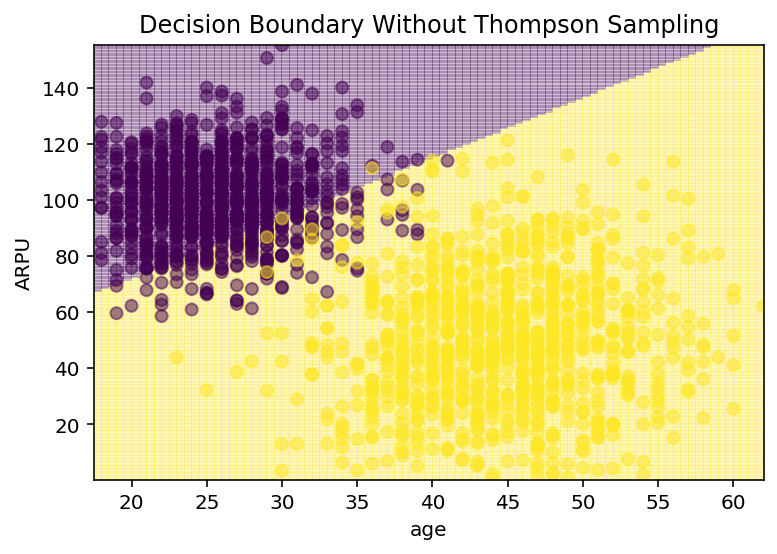

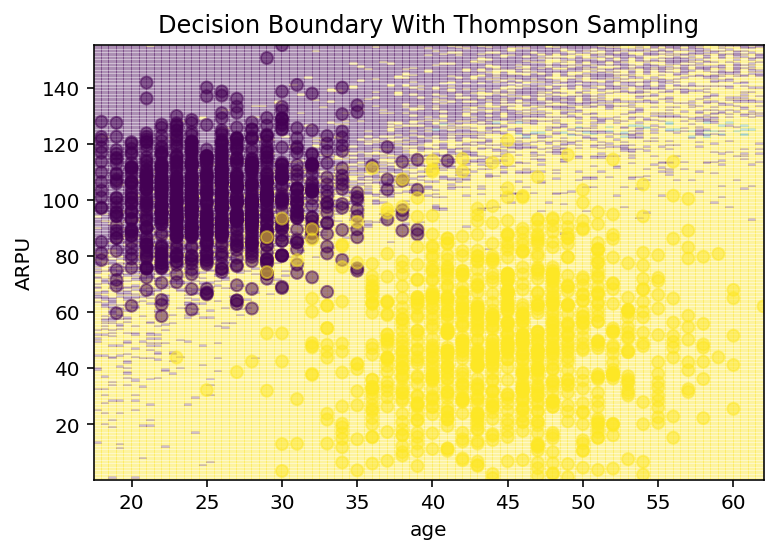

took  5.06  seconds.


In [6]:
def plot_decision_boundary(model, X, Y, h=1, scale=1., parallelize=True, title='decision boundary', thompson=False, classic=False, n_threads=-1, flip_colors=True):
    ftnames = X.columns[0], X.columns[1]
    X = X.values
    #model.fit(X[:, :2], Y)
    x_min = X[:, 1].min() - .5
    x_max = X[:, 1].max() + .5
    y_min = X[:, 0].min() - .5
    y_max = X[:, 0].max() + .5
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h)
    )
    if classic:
        Z = model.classic_predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson)
    else:
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()]/scale, thompson=thompson, parallelize=parallelize)

    # Put the result into a color plot.
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, alpha=.25)

    # Add the training points to the plot.
    if flip_colors:
        Y = np.where(np.array(Y)==1, 0, 1)
    plt.scatter(X[:, 1], X[:, 0], c=Y, alpha=.5);
    #plt.scatter(X[:, 1], X[:, 0], c='black', alpha=.1);


    plt.xlabel(ftnames[1])
    plt.ylabel(ftnames[0])

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max());
    plt.title(title)
    plt.show()
    
    
from time import time
X = group1 + group2
Y = [1 for x in range(1000)] + [0 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df



plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling')

t1 = time()
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, parallelize=True, n_threads=3, title='Decision Boundary With Thompson Sampling')
print('took ', round(time()-t1, 2), ' seconds.')

## A Note on Thompson Sampling
As you can see above, the output of the model changes when we apply Thompson Sampling. This is how the model explores: in regions where it is uncertain (say, where the customer groups overlap), Thompson sampling returns a mix of recommendations between the two groups. This allows the model to further optimize with future examples. Thus, Thompson sampling gives us a "smart" way to explore.<br><br> While the model is confused when a customer lies just between the two groups, it can very confidently exclude the "bad" second promotion as an option. However, in regions where very few customers appear, the "bad" promotion is still recommended occasionally, as the model has no reason to think this is a bad choice where there are just too few samples to be sure.

## Neural Network
An extension of this simple model uses a neural network to build more robust features for the linear model. Let's try one such model here.<br><br>
As a default, SpaceBandits implements a single 50-node hidden layer nn model. Here, we add an additional hidden layer with 12 nodes. Using a smaller final layer reduces the computation cost of Thompson sampling. During training, the model will stop and train its neural network at a specified number of updates (default: every 50 updates.)<br><br>
### Feature Scaling
Neural Networks prefer features to have a mean of zero and a standard deviation of one, which we can get by scaling our data. By default, the NeuralBandits model will scale the data. (To turn this behavior off, pass do_scaling=False to the constructor.)

Training neural_model-bnn for 100 steps...
137.9185791015625
138.24484252929688
110.18314361572266
133.55201721191406
116.25247955322266
96.01466369628906
133.5564727783203
96.5142593383789
131.33834838867188
125.81151580810547
99.99787139892578
145.8859405517578
87.9908676147461
150.89735412597656
121.66365814208984
123.58637237548828
138.71356201171875
107.83352661132812
91.3864517211914
116.97547149658203
104.62105560302734
116.82275390625
109.7734375
112.84794616699219
119.31890106201172
108.90776824951172
110.91531372070312
74.85750579833984
102.6319351196289
87.7075424194336
77.88569641113281
87.06397247314453
115.72100830078125
89.09090423583984
116.20874786376953
70.884521484375
105.15908813476562
122.92546081542969
117.07793426513672
78.56465911865234
122.16465759277344
128.75054931640625
107.34394836425781
119.51681518554688
111.11210632324219
141.98648071289062
133.05838012695312
110.82610321044922
108.26438903808594
83.61888885498047
93.49137115478516
127.27926635742188
103

82.12171936035156
118.49675750732422
115.17237091064453
131.23374938964844
143.77206420898438
107.11315155029297
82.3893051147461
124.61454772949219
119.6333999633789
146.2410125732422
103.3921127319336
72.85701751708984
137.24937438964844
130.2164306640625
115.52766418457031
Training neural_model-bnn for 100 steps...
115.06505584716797
147.34889221191406
117.28761291503906
112.7260971069336
105.44619750976562
94.44874572753906
139.75076293945312
157.64425659179688
120.5632553100586
145.2495880126953
100.2466812133789
161.7670135498047
148.53538513183594
159.17617797851562
93.35135650634766
128.93698120117188
120.18523406982422
119.08180236816406
178.71102905273438
162.8900604248047
129.8796844482422
142.5557403564453
159.42002868652344
114.43109130859375
150.3858184814453
140.71119689941406
93.17916107177734
119.74818420410156
160.00103759765625
131.94683837890625
108.57587432861328
149.83209228515625
162.2458038330078
168.8517303466797
95.8045425415039
117.48033905029297
89.027717590

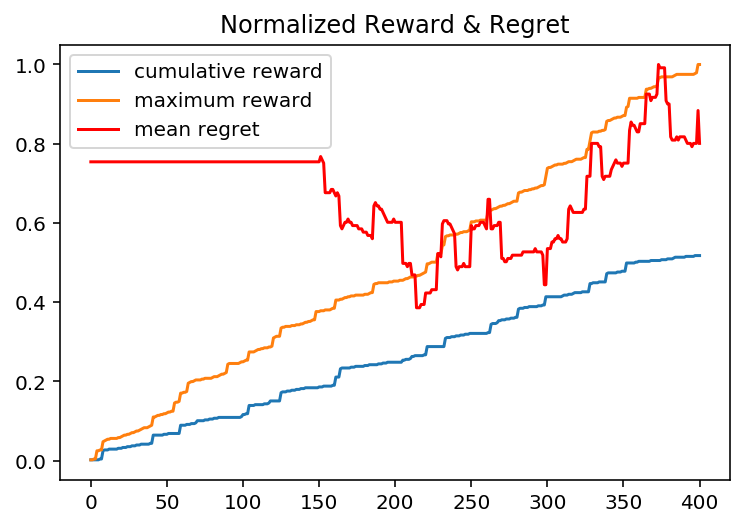

In [7]:
from space_bandits import NeuralBandits

num_actions = 3
num_features = 2
memory_size = 10000

neural_model = NeuralBandits(num_actions, num_features, initial_pulls=100, memory_size=memory_size, layer_sizes=[50, 12])
assert neural_model.data_h.memory_size == memory_size

records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=400)

## Saving Neural Models
As with linear models, neural models can be saved and re-loaded during training. Now that we've migrated to torch, we can use the same load function and a simple pickle to load/save models.

In [8]:
neural_model.save('test_model')
neural_model = load_model('test_model')

Training neural_model-bnn for 100 steps...
125.5521240234375
111.30374908447266
158.86141967773438
120.17047119140625
115.17391204833984
120.80997467041016
161.58888244628906
86.65415954589844
155.96658325195312
132.32154846191406
97.86457061767578
98.91896057128906
103.28946685791016
121.31852722167969
156.77041625976562
122.05738067626953
115.55267333984375
85.06609344482422
85.7653579711914
102.66374969482422
73.62387084960938
109.09555053710938
163.13742065429688
103.27072143554688
138.8700714111328
114.3176040649414
127.87521362304688
133.3576202392578
114.51213073730469
137.78297424316406
121.82589721679688
149.34310913085938
127.65898895263672
115.9600601196289
101.96883392333984
150.25833129882812
130.8250732421875
103.0930404663086
92.32599639892578
139.1470947265625
102.85356903076172
80.23561096191406
160.1484375
98.59822845458984
98.16291809082031
139.4290771484375
109.6845932006836
114.98838806152344
96.74820709228516
120.86763000488281
119.50116729736328
80.06239318847656

110.77568817138672
91.2050552368164
169.6420440673828
145.180419921875
156.85447692871094
133.50550842285156
91.81653594970703
146.23812866210938
167.1898651123047
124.58084869384766
139.92103576660156
159.23512268066406
Training neural_model-bnn for 100 steps...
192.05276489257812
175.69973754882812
203.06640625
173.7688751220703
122.33199310302734
157.0135040283203
140.0973358154297
162.80787658691406
162.61631774902344
133.5670623779297
169.6503143310547
134.17901611328125
115.77064514160156
110.33192443847656
139.25424194335938
179.85433959960938
163.332275390625
134.0729217529297
121.62662506103516
103.89420318603516
150.69068908691406
170.43099975585938
132.902099609375
134.3133544921875
179.09535217285156
179.2459716796875
151.01528930664062
149.0179443359375
116.3509521484375
150.78564453125
122.54345703125
128.9031524658203
117.43431091308594
155.4739990234375
151.0476531982422
152.29598999023438
150.6570587158203
138.4417266845703
112.059326171875
128.42581176757812
161.37129

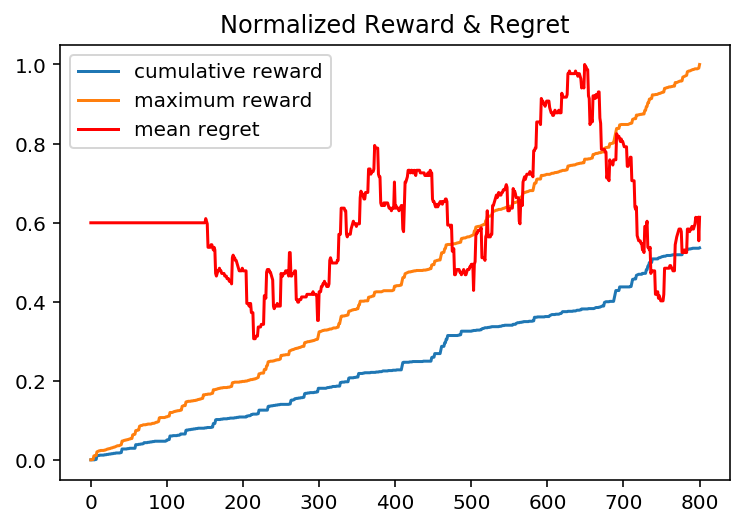

In [9]:
records = iterate_model(neural_model, optimal_choices, 401, plot_frequency=800, records=records)

The neural model performs comparably to the linear model in this case; it's valuable for situations where linear decision boundaries are not effective.

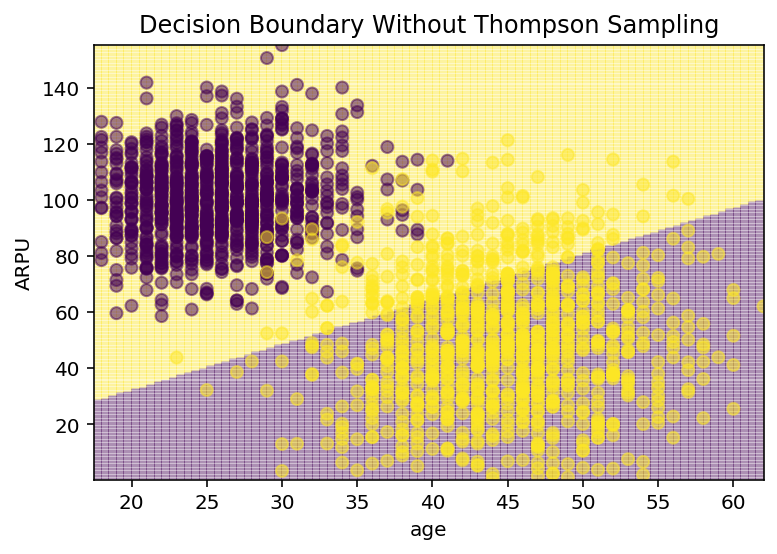

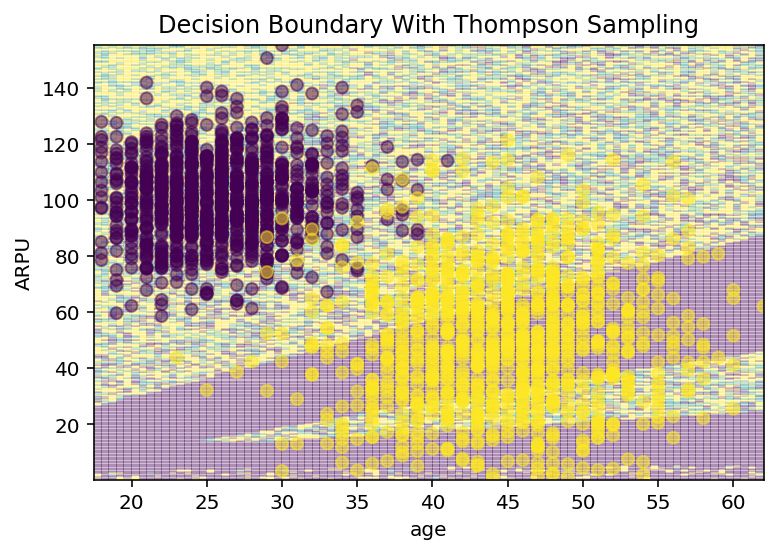

took  5.609967947006226


In [10]:
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=False, title='Decision Boundary Without Thompson Sampling', n_threads=3)


t1 = time()
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=True, parallelize=True, title='Decision Boundary With Thompson Sampling', n_threads=3)
print('took ', time() - t1)

## Training from Historic Data
Online learning is great, but in practice we can't always see rewards immediately. SpaceBandits provides methods for rapidly training from historic data as well.<br><br>
These methods play nice with online methods; batch training with new calls to .fit will retain information from previous calls to .fit.

In [11]:
def generate_dataframe(n_rows):
    df = pd.DataFrame()
    ages = []
    ARPUs = []
    actions = []
    rewards = []
    for i in range(n_rows):
        cust = get_customer()
        reward_vec = get_rewards(cust)
        context = np.array([cust[1]])
        ages.append(context[0, 0])
        ARPUs.append(context[0, 1])
        action = np.random.randint(0,3)
        actions.append(action)
        reward = reward_vec[action]
        rewards.append(reward)

    df['age'] = ages
    df['ARPU'] = ARPUs
    df['action'] = actions
    df['reward'] = rewards

    return df

df = generate_dataframe(2000)

df.head()

age       ARPU  action  reward
0  18.0  94.377485       0       0
1  45.0  76.146564       2       0
2  50.0  40.026453       2       0
3  23.0  91.815914       0      10
4  44.0  16.992892       0       0

## Preparing Data for Training
As can be seen above, rows of data must be organized into tripets: features, actions, and rewards. In this case, these records represent a customer (age, ARPU), action (which promotion they saw), and what reward was earned (how much money the customer spent on the promotion.)

185.4262237548828
220.53025817871094
142.10870361328125
109.06735229492188
103.74557495117188
145.5675048828125
85.53483581542969
119.60794067382812
172.18270874023438
106.42200469970703
122.7237319946289
89.22055053710938
113.9801254272461
99.2601318359375
155.9261016845703
128.36705017089844
115.30418395996094
132.0775604248047
111.21578979492188
120.123779296875
129.6875457763672
124.3861083984375
107.71381378173828
158.1014404296875
107.0167007446289
113.41194152832031
119.29389953613281
98.45328521728516
139.21458435058594
113.24232482910156
141.55006408691406
145.3834686279297
137.6877899169922
130.0692596435547
92.72152709960938
142.08584594726562
154.65602111816406
96.76911163330078
89.31990814208984
140.59349060058594
108.48694610595703
137.37640380859375
112.53182220458984
93.03290557861328
95.80013275146484
93.3800277709961
111.7505874633789
118.36251068115234
119.73656463623047
101.82830810546875
80.25628662109375
119.35366821289062
109.4875259399414
116.41797637939453
139.

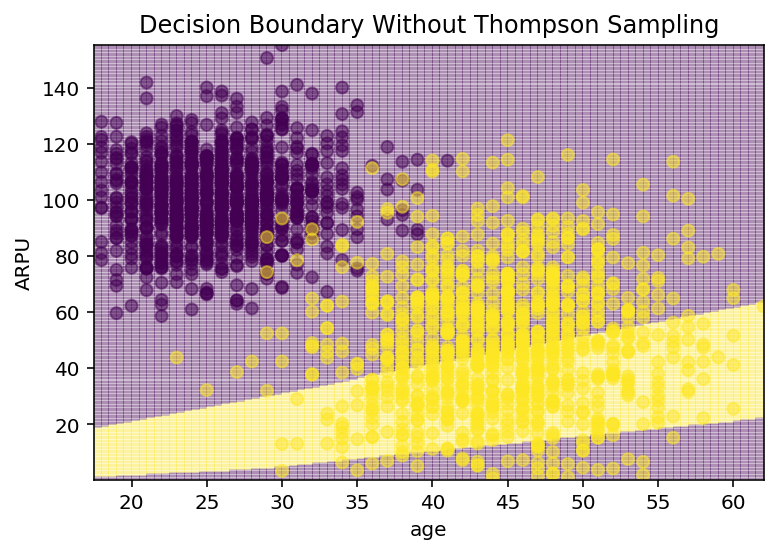

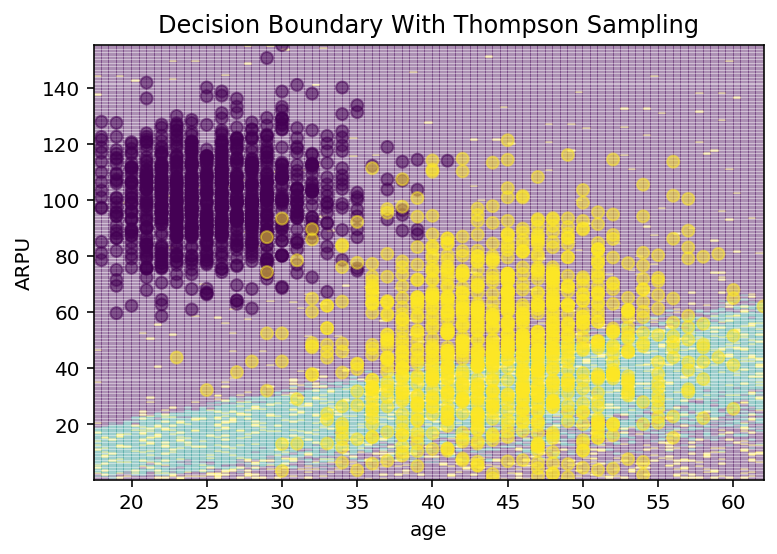

In [13]:
#split data into triplets
contexts = df[['age', 'ARPU']]
actions = df['action']
rewards = df['reward']

#initialize new neural model
new_model = NeuralBandits(3, 2, layer_sizes=[50, 12], verbose=False)
#call .fit method; num_updates will repeat training n times
new_model.fit(contexts, actions, rewards)

plot_decision_boundary(new_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling')
plot_decision_boundary(new_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', n_threads=3)

We see here that the model learns a reasonable decision boundary; Thompson sampling reveals it is still eager to explore, but it will generally recommend well for customers in well-explored locations in the feature space.

## Biased Data
The above training data had random promotion assignments. Let's say our training data came from a previous campaign, where the marketing department sent promotion based on the following rules:<br>
1. Customers in the range 0-50 ARPU recieve promotion 1. 
2. Customers in the range 51-100 ARPU recieve promotion 2.
3. Customers with greater than 100 ARPU recieve promotion 3.

This introduces bias into our training data. Let's see what effect this has on our neural model optimization.

In [14]:
def generate_biased_dataframe(n_rows):
    df = pd.DataFrame()
    ages = []
    ARPUs = []
    actions = []
    rewards = []
    for i in range(n_rows):
        cust = get_customer()
        reward_vec = get_rewards(cust)
        context = np.array([cust[1]])
        age = context[0, 0]
        ARPU = context[0, 1]
        ages.append(age)
        ARPUs.append(ARPU)
        if ARPU <= 50:
            action = 0
        elif ARPU <= 100:
            action = 1
        else:
            action = 2
        actions.append(action)
        reward = reward_vec[action]
        rewards.append(reward)

    df['age'] = ages
    df['ARPU'] = ARPUs
    df['action'] = actions
    df['reward'] = rewards

    return df

df = generate_biased_dataframe(2000)

69.65805053710938
42.178001403808594
23.094669342041016
37.19634246826172
29.49225425720215
34.29969787597656
49.17152404785156
53.856361389160156
16.38130760192871
46.890689849853516
47.75663757324219
48.205047607421875
60.517391204833984
18.456623077392578
24.710538864135742
48.75583267211914
22.84364128112793
39.50307846069336
20.641921997070312
49.42219161987305
28.998111724853516
54.13554382324219
28.57254981994629
14.347260475158691
47.33959197998047
33.17247772216797
21.47390365600586
47.738189697265625
16.256099700927734
26.698495864868164
40.60346603393555
34.62735366821289
46.66852951049805
35.174251556396484
36.846405029296875
66.76773071289062
30.54124641418457
43.37841796875
43.12800979614258
23.032472610473633
24.923824310302734
27.245054244995117
32.23169708251953
33.450950622558594
31.22698211669922
43.41762924194336
38.94605255126953
32.78753662109375
43.636985778808594
17.762718200683594
54.54143142700195
39.2920036315918
42.753150939941406
54.95753860473633
19.387159

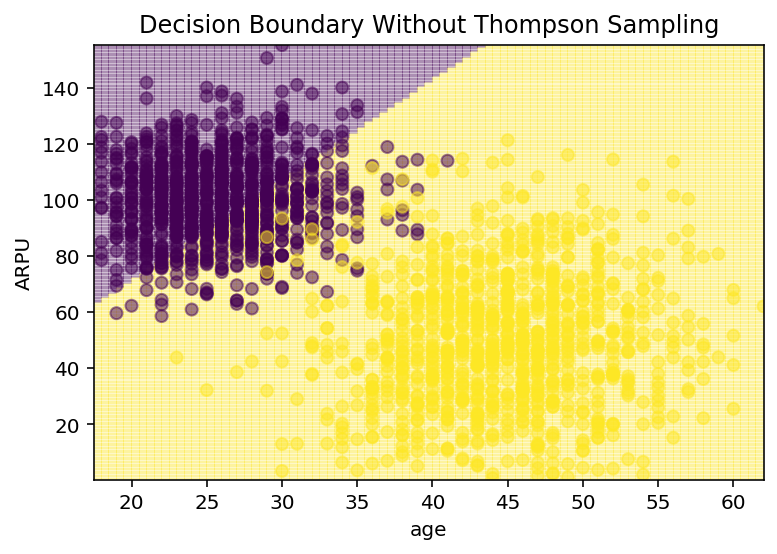

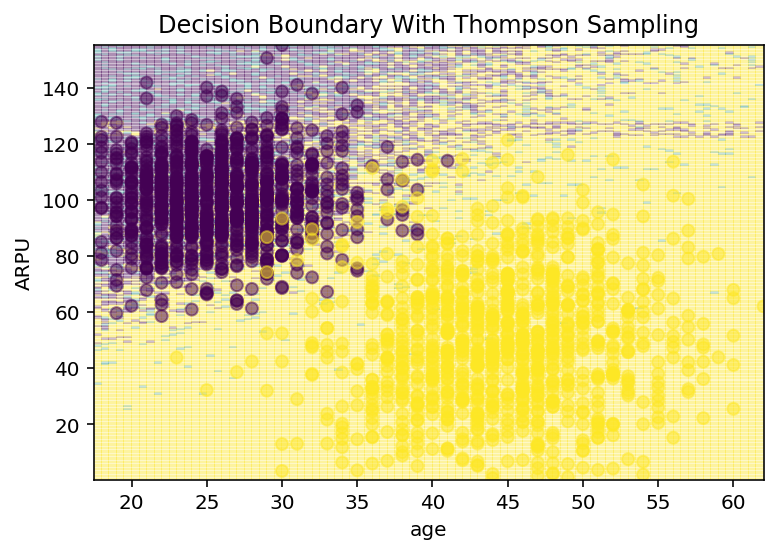

In [16]:
contexts = df[['age', 'ARPU']]
actions = df['action']
rewards = df['reward']

bias_model = NeuralBandits(3, 2, layer_sizes=[50, 12], verbose=False)
bias_model.fit(contexts, actions, rewards)

plot_decision_boundary(bias_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling')
plot_decision_boundary(bias_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', n_threads=3)

We see that the net effect of using biased data is model uncertainty; Thompson sampling gives us exploratory behavior even after training on 2000 examples. There do appear to be certain regions in the feature space that have converged to optimal solutions.

## Nonlinear Problem
The previous example can be solved with a simple linear decision boundary. Let's try a more complicated example.

In [17]:
import numpy as np
import pandas as pd
from random import random
import matplotlib.pyplot as plt
##Generate Data

def get_customer(ctype=None):
    """Customers come from two feature distributions.
    Class 1: mean age 25, var 5 years, min age 18
             mean ARPU 100, var 15
    Class 2: mean age 45, var 6 years
             mean ARPU 50, var 25
    """
    if ctype is None:
        ctype = randint(0,2)
    age = 0
    ft = -1
    if ctype == 0:
        while age < 18:
            age = np.random.normal(25, 5)
            ft = 125 - .1*(age-25)*(age-25) + np.random.normal(0, 4)
    if ctype == 1:
        while age < 18:
            age = np.random.normal(35, 2)
        while ft < 0:
            ft = np.random.normal(75, 3)
    if ctype == 2:
        while age < 18:
            age = np.random.normal(45, 6)
            ft = 25 + .25*(age-45)*(age-45) + np.random.normal(0, 4)
    age = round(age)
    return ctype, (age, ft)

def get_rewards(customer):
    """
    There are three actions:
    promo 1: low value. 10 dollar if accept
    promo 2: mid value. 25 dollar if accept
    promo 3: high value. 100 dollar if accept
    
    Expected Value Matrix:
    
           group1|group2|group3
    ----------------------------
    promo1|  $9  |  $1  |  $1
    ----------------------------
    promo2| $2.5 | $12.5| $1.25
    ----------------------------
    promo3| $1   |  $5  | $25
    
    We can see each group has an optimal choice.
    """
    if customer[0] == 0: #group 1 customer
        if random() > .1:
            reward1 = 10
        else:
            reward1 = 0
        if random() > .90:
            reward2 = 25
        else:
            reward2 = 0
        if random() > .99:
            reward3 = 100
        else:
            reward3 = 0
    if customer[0] == 1: #group 2 customer
        if random() > .9:
            reward1 = 10
        else:
            reward1 = 0
        if random() > .50:
            reward2 = 25
        else:
            reward2 = 0
        if random() > .95:
            reward3 = 100
        else:
            reward3 = 0
    if customer[0] == 2: #group 3 customer
        if random() > .9:
            reward1 = 10
        else:
            reward1 = 0
        if random() > .95:
            reward2 = 25
        else:
            reward2 = 0
        if random() > .75:
            reward3 = 100
        else:
            reward3 = 0
    return np.array([reward1, reward2, reward3])

def get_cust_reward():
    """returns a customer and reward vector"""
    cust = get_customer()
    reward = get_rewards(cust)
    age = cust[1]
    return np.array([age]), reward

In [18]:
customers = [get_customer(ctype=0) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (10000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=1) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
print('group 1 expected rewards: (10000 samples)', rewards.mean(axis=0))

customers = [get_customer(ctype=2) for x in range(100000)]
rewards = np.concatenate([np.expand_dims(get_rewards(cust), axis=0) for cust in customers])
rewards.mean(axis=0)
print('group 2 expected rewards: (10000 samples)', rewards.mean(axis=0))

optimal_choices = [0, 1, 2]
#confirm expected rewards

group 1 expected rewards: (10000 samples) [9.0093  2.53825 1.022  ]
group 1 expected rewards: (10000 samples) [ 0.9939  12.55025  5.067  ]
group 2 expected rewards: (10000 samples) [ 0.9837   1.24975 24.966  ]


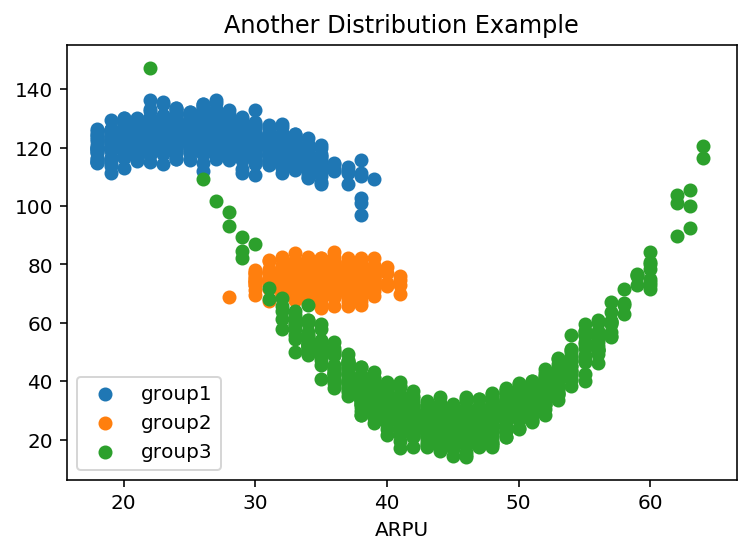

In [19]:
group1 = []
group2 = []
group3 = []
for i in range(1000):
    group1.append(get_customer(0))
    group2.append(get_customer(1))
    group3.append(get_customer(2))
    
plt.scatter([x[1][0] for x in group1], [x[1][1] for x in group1], label='group1')
plt.scatter([x[1][0] for x in group2], [x[1][1] for x in group2], label='group2')
plt.scatter([x[1][0] for x in group3], [x[1][1] for x in group3], label='group3')
plt.xlabel('age')
plt.xlabel('ARPU')
plt.title('Another Distribution Example')
plt.legend();

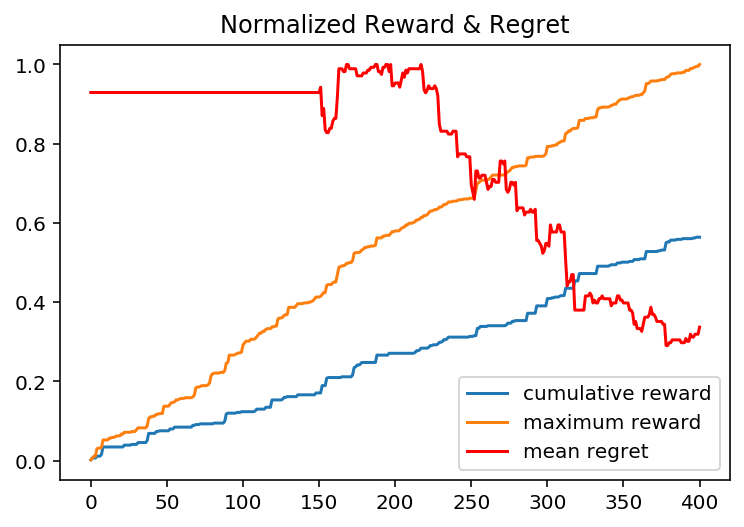

In [20]:
num_actions = 3
num_features = 2

linear_model = LinearBandits(num_actions, num_features, initial_pulls=100)

records = iterate_model(linear_model, optimal_choices, 401, plot_frequency=400)

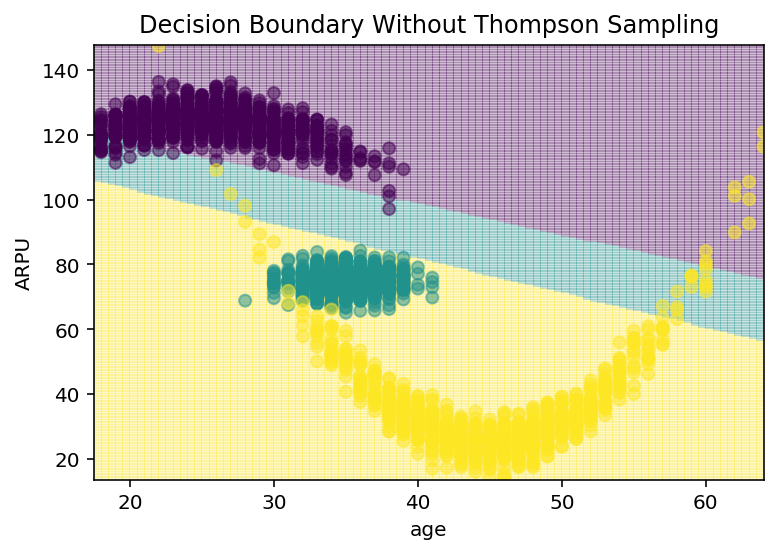

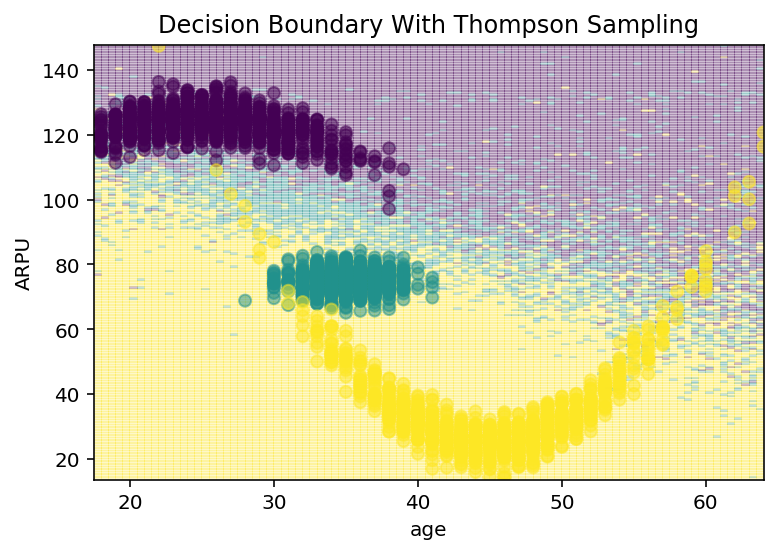

In [21]:
X = group1 + group2 + group3
X = [x[1] for x in X]
Y = [0 for x in range(1000)] + [1 for x in range(1000)] + [2 for x in range(1000)]
ages = [x[0] for x in X]
ARPUs = [x[1] for x in X]
as_df = pd.DataFrame()
as_df['ARPU'] = ARPUs
as_df['age'] = ages
X = as_df

plot_decision_boundary(linear_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling', flip_colors=False)
plot_decision_boundary(linear_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', flip_colors=False)

39.72380447387695
71.0349349975586
96.30065155029297
95.95487213134766
124.90570831298828
104.7689437866211
111.33540344238281
64.94403076171875
69.47565460205078
49.43587112426758
82.4415283203125
80.09774017333984
96.91213989257812
60.687591552734375
61.36042022705078
54.82308578491211
87.92244720458984
61.579864501953125
76.37474822998047
95.37291717529297
60.897586822509766
70.11874389648438
101.86687469482422
88.38314056396484
81.77783966064453
62.42354965209961
85.38311004638672
82.43770599365234
82.6766128540039
76.37367248535156
53.65757751464844
126.6361083984375
98.81906127929688
114.63269805908203
52.88898468017578
80.83641815185547
33.9517936706543
49.908206939697266
87.22721862792969
94.91841888427734
73.79275512695312
25.221576690673828
50.56280517578125
65.79053497314453
71.64533233642578
84.26728057861328
88.17842864990234
50.9465217590332
75.83561706542969
111.65341186523438
49.11111831665039
48.678775787353516
63.895545959472656
49.1303596496582
70.67050170898438
50.7

86.12887573242188
118.39153289794922
87.65995025634766
87.02124786376953
62.16611099243164
77.5586166381836
94.9519271850586
73.6782455444336
108.1737289428711
70.96781158447266
75.31452178955078
79.6390380859375
86.2256851196289
98.10020446777344
80.73701477050781
73.5337905883789
66.97470092773438
83.91088104248047
106.84123992919922
79.3550796508789
124.37858581542969
92.21907806396484
85.41312408447266
106.89356231689453
76.97943878173828
88.87932586669922
144.90322875976562
82.87645721435547
80.96540832519531
89.74589538574219
85.04701232910156
73.6447982788086
89.53233337402344
119.89714813232422
91.10314178466797
91.25616455078125
93.74346160888672
115.7027587890625
107.8154067993164
91.09847259521484
88.9617691040039
115.6220703125
89.27130889892578
100.95673370361328
118.97342681884766
67.535888671875
103.15428161621094
98.12031555175781
102.54605865478516
55.979305267333984
104.22162628173828
98.39842224121094
113.96928405761719
91.52448272705078
80.69103240966797
91.14826202

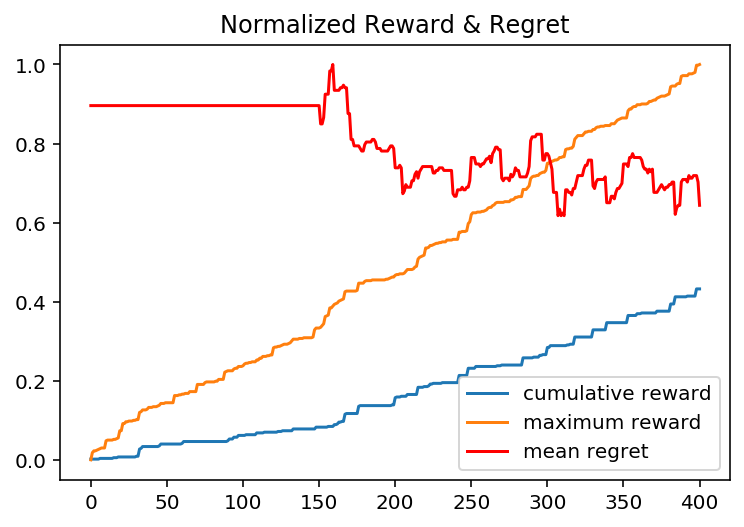

142.37362670898438
156.36402893066406
157.03173828125
170.8084259033203
176.91571044921875
144.58694458007812
139.1562042236328
136.0557861328125
130.1309814453125
145.83322143554688
142.79345703125
125.36241149902344
186.54928588867188
204.7881622314453
126.20955657958984
166.67330932617188
117.93473052978516
143.9574432373047
156.2703399658203
133.78062438964844
200.27099609375
134.26077270507812
163.478271484375
137.564697265625
179.9279327392578
152.31478881835938
155.0784912109375
149.70985412597656
146.21615600585938
175.55174255371094
151.42904663085938
137.38027954101562
210.90419006347656
122.72525024414062
113.91702270507812
128.24693298339844
118.33445739746094
184.7716064453125
124.42001342773438
180.42332458496094
117.82288360595703
150.59854125976562
157.07447814941406
147.8353271484375
177.39218139648438
151.8049774169922
184.976318359375
102.7484130859375
203.3767547607422
141.14430236816406
150.3368377685547
158.65594482421875
103.9101791381836
176.62045288085938
139.4

144.22286987304688
178.69129943847656
139.73818969726562
128.36886596679688
139.4741973876953
137.8065948486328
150.68353271484375
135.8041534423828
195.62461853027344
126.74897003173828
183.0889434814453
160.48947143554688
116.42538452148438
167.96742248535156
153.22296142578125
188.74404907226562
146.52005004882812
128.23388671875
132.51873779296875
171.8296661376953
213.1720428466797
173.5240478515625
192.217041015625
178.60693359375
172.1017608642578
137.45272827148438
178.9721221923828
124.3683853149414
159.36416625976562
160.59347534179688
177.8509521484375
120.9554214477539
178.79180908203125
159.89576721191406
168.90338134765625
180.91615295410156
143.30474853515625
149.6922607421875
153.44334411621094
172.95809936523438
118.69377899169922
162.9614715576172
162.6866455078125
164.59982299804688
191.2646942138672
133.58343505859375
171.7309112548828
194.50364685058594
126.97531127929688
105.62352752685547
156.59640502929688
170.15399169921875
214.37820434570312
165.4546356201172


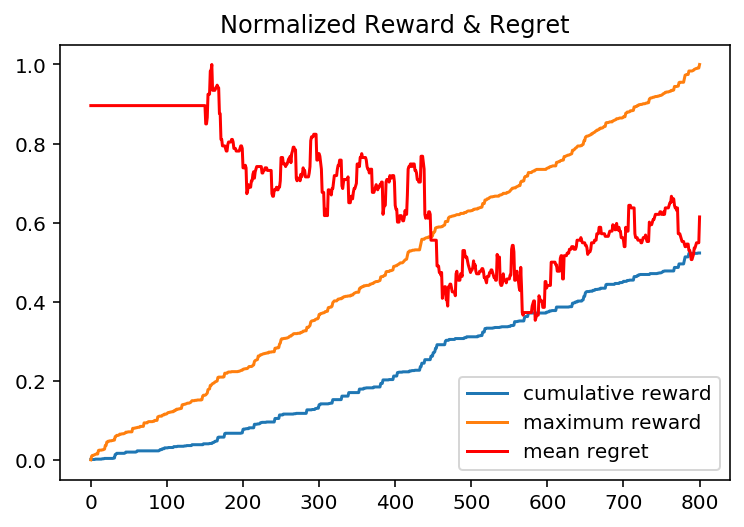

162.26710510253906
127.9891586303711
159.5918426513672
155.73397827148438
168.51022338867188
131.9060821533203
155.67718505859375
155.95591735839844
176.2262725830078
193.93121337890625
176.63172912597656
120.52078247070312
167.98117065429688
159.65560913085938
138.62413024902344
110.107421875
154.0784912109375
190.1755828857422
200.3231964111328
195.8573455810547
188.1404571533203
150.30484008789062
159.21145629882812
153.0827178955078
199.7252960205078
158.3453826904297
150.68031311035156
187.176025390625
149.70465087890625
133.39059448242188
148.34072875976562
148.939453125
186.68276977539062
156.0670623779297
123.93514251708984
170.6881103515625
125.95001220703125
224.1219024658203
150.857177734375
157.23973083496094
159.84852600097656
131.13681030273438
167.94512939453125
148.79470825195312
163.92433166503906
138.579345703125
168.34231567382812
190.0329132080078
158.9832305908203
203.53634643554688
142.37330627441406
155.7185821533203
169.59674072265625
149.6975860595703
105.75363

/home/alliedtoasters/sbanditsjunk/space_bandits/neural_linear.py:281: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  multivariates = [np.random.multivariate_normal(mus[j], covs[j]) for j in range(n_rows)]


203.89332580566406
189.48184204101562
178.5215301513672
179.3505401611328
160.60623168945312
214.6413116455078
151.99295043945312
150.957763671875
173.4283447265625
180.06922912597656
146.48179626464844
176.2669677734375
139.7642822265625
143.40823364257812
139.65745544433594
187.33045959472656
143.0561065673828
203.2667236328125
172.610595703125
165.3499755859375
239.18235778808594
155.2207489013672
154.90419006347656
142.31524658203125
200.7904052734375
180.21038818359375
191.50355529785156
170.2787628173828
149.56781005859375
144.43955993652344
186.29229736328125
180.510986328125
197.29684448242188
210.27015686035156
147.89573669433594
184.2878875732422
124.6278305053711
150.3220977783203
131.5719451904297
172.31675720214844
162.74127197265625
167.4967498779297
204.53826904296875
178.64956665039062
148.24826049804688
123.61066436767578
122.55748748779297
194.58786010742188
164.59768676757812
159.72325134277344
181.21788024902344
207.46054077148438
191.0728302001953
186.3919219970703

133.26353454589844
138.05361938476562
200.2291717529297
179.515869140625
217.47512817382812
216.5429229736328
170.0518035888672
204.8653106689453
165.65673828125
184.78652954101562
180.73129272460938
157.73626708984375
154.25779724121094
211.24163818359375
183.97825622558594
201.10833740234375
193.32046508789062
174.57748413085938
215.31138610839844
185.3600616455078
200.9076690673828
166.2703857421875
187.50962829589844
198.33253479003906
208.55975341796875
213.59800720214844
204.35447692871094
217.0952606201172
250.9089813232422
199.1146240234375
193.53662109375
200.21739196777344
187.18905639648438
183.98486328125
180.97215270996094
219.11375427246094
187.6322479248047
207.0879669189453
167.35491943359375
135.74087524414062
165.0951690673828
192.2600860595703
172.77755737304688
183.5322723388672
230.90699768066406
178.5658416748047
190.59278869628906
205.86936950683594
160.76145935058594
159.57960510253906
160.0315399169922
217.9474639892578
194.489013671875
192.2306365966797
181.52

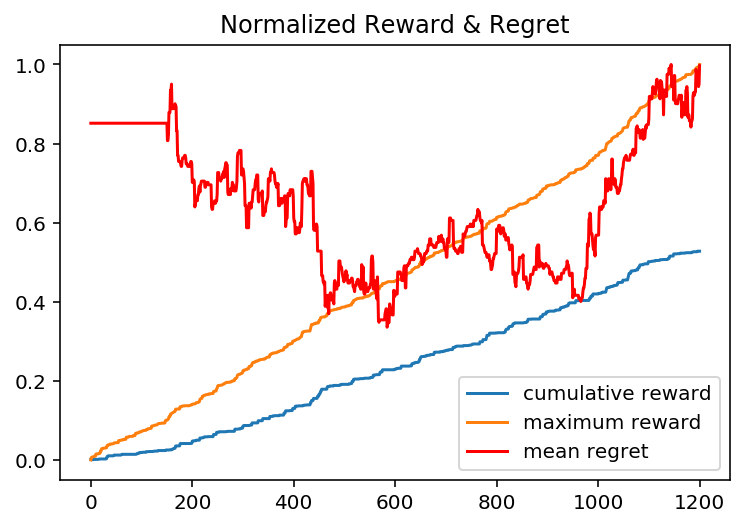

196.8846435546875
225.12852478027344
173.12388610839844
164.8074951171875
182.1586151123047
153.73934936523438
182.5170135498047
105.55121612548828
153.9661102294922
176.08966064453125
154.04879760742188
210.89329528808594
162.6538543701172
191.82313537597656
192.10227966308594
155.8812255859375
159.3568115234375
181.1111602783203
226.4358367919922
185.34451293945312
188.0314483642578
127.26699829101562
179.8221435546875
258.612548828125
140.17269897460938
195.84991455078125
197.5702667236328
189.08506774902344
187.12120056152344
222.63319396972656
157.43704223632812
172.44781494140625
183.90977478027344
154.4364776611328
198.00912475585938
200.41009521484375
187.8213653564453
177.1704559326172
192.92916870117188
195.43344116210938
164.9870147705078
207.7292022705078
163.01132202148438
211.2328643798828
144.79757690429688
164.88668823242188
165.99888610839844
191.87916564941406
169.10398864746094
123.56839752197266
197.8515167236328
179.13865661621094
188.33242797851562
136.15281677246

168.6783905029297
146.7122039794922
210.29458618164062
136.82887268066406
205.9629669189453
178.67495727539062
252.00430297851562
149.08863830566406
169.54217529296875
165.2112579345703
162.41038513183594
149.50860595703125
169.6777801513672
200.24679565429688
191.35107421875
171.13827514648438
197.18067932128906
178.92710876464844
216.82579040527344
143.1768798828125
147.4408416748047
200.9376983642578
210.5382080078125
148.6758270263672
182.2508544921875
163.310791015625
181.03956604003906
147.721923828125
150.72145080566406
201.45346069335938
147.5884246826172
177.04225158691406
158.5432586669922
154.23126220703125
139.23843383789062
185.60299682617188
109.14947509765625
128.04452514648438
167.96420288085938
190.1457061767578
187.10255432128906
201.60491943359375
203.3668975830078
167.6031494140625
179.29714965820312
178.9312744140625
177.91102600097656
156.8967742919922
175.594482421875
154.62298583984375
202.79986572265625
150.07846069335938
182.10214233398438
188.66830444335938
1

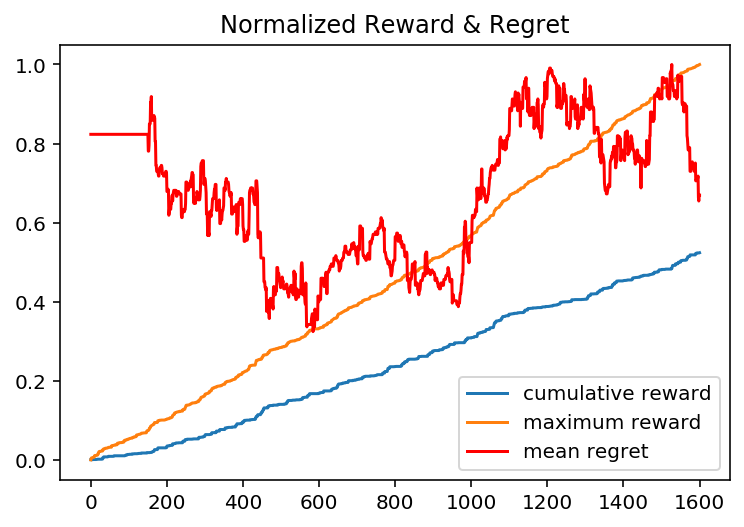

259.232177734375
214.54429626464844
176.6171875
141.6547088623047
195.8705596923828
186.2418212890625
154.40591430664062
206.76309204101562
164.32940673828125
182.0985870361328
151.14767456054688
119.59080505371094
169.09771728515625
143.4814453125
190.25193786621094
198.11964416503906
155.72659301757812
147.95298767089844
141.6465301513672
196.2882537841797
158.7181396484375
186.08639526367188
102.82769012451172
196.03659057617188
213.50701904296875
199.53257751464844
197.9018096923828
192.15342712402344
159.458740234375
174.64967346191406
219.2156524658203
188.29515075683594
166.6608428955078
160.82582092285156
186.58670043945312
197.74977111816406
172.99392700195312
164.07330322265625
164.52716064453125
178.291748046875
217.68972778320312
169.87335205078125
158.5974884033203
215.73565673828125
203.4698944091797
214.4251708984375
217.81312561035156
204.30162048339844
174.78912353515625
185.22573852539062
209.84933471679688
181.25721740722656
181.977294921875
158.0054168701172
149.120

194.29527282714844
132.3223876953125
162.4710693359375
176.15835571289062
203.05943298339844
152.94212341308594
188.108154296875
169.4649658203125
209.6432647705078
186.0796661376953
157.28721618652344
215.1627655029297
168.40280151367188
173.22021484375
148.29591369628906
182.03521728515625
202.11695861816406
137.7540740966797
209.04254150390625
187.64266967773438
238.03421020507812
235.9619598388672
168.347900390625
191.1270751953125
149.360107421875
152.97889709472656
174.44729614257812
128.296875
204.09014892578125
172.29086303710938
188.36546325683594
158.0536651611328
197.651123046875
165.26663208007812
152.3656005859375
187.35475158691406
159.01699829101562
169.11073303222656
196.60337829589844
209.43690490722656
165.51583862304688
145.50521850585938
163.14109802246094
195.60130310058594
184.4111328125
206.26454162597656
205.9817657470703
158.84573364257812
174.44232177734375
164.97811889648438
155.26351928710938
168.40655517578125
174.814697265625
207.85202026367188
188.6640777

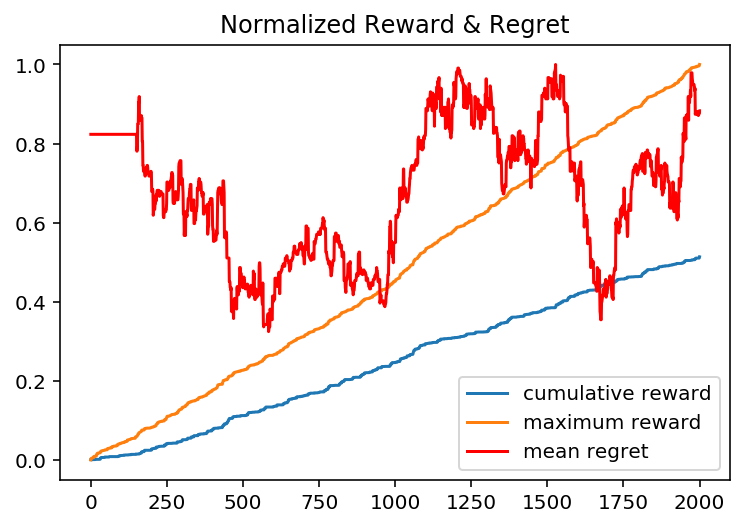

138.29283142089844
177.93377685546875
166.63047790527344
154.46176147460938
152.03857421875
198.4147491455078
166.66128540039062
157.20803833007812
199.0248565673828
119.71251678466797
156.40194702148438
148.92396545410156
187.04701232910156
182.2675323486328
177.7889862060547
214.8833770751953
178.88067626953125
181.8340301513672
189.25514221191406
153.3871612548828
125.35370635986328
179.37188720703125
196.90464782714844
203.3153533935547
157.1469268798828
145.18946838378906
229.5848388671875
146.66078186035156
167.06182861328125
194.36521911621094
158.7303466796875
176.56541442871094
190.78280639648438
143.51986694335938
204.190185546875
212.99649047851562
207.37437438964844
170.15853881835938
179.92079162597656
171.02474975585938
173.42347717285156
187.20175170898438
225.48745727539062
230.7669677734375
188.3625946044922
185.85780334472656
212.6756591796875
260.333740234375
233.42681884765625
156.35011291503906
170.93057250976562
176.39111328125
198.08538818359375
137.6056365966797

211.23106384277344
173.1627655029297
180.6719970703125
172.7133331298828
144.03970336914062
188.84422302246094
177.11541748046875
197.89248657226562
171.77725219726562
205.71630859375
134.9306182861328
191.44366455078125
151.87039184570312
153.38916015625
207.087646484375
183.5565643310547
197.99398803710938
188.91348266601562
211.83917236328125
147.5432586669922
144.85565185546875
205.01426696777344
194.58746337890625
169.9427947998047
156.51148986816406
193.67543029785156
210.22518920898438
198.38571166992188
168.15444946289062
188.74124145507812
148.5092315673828
181.97042846679688
173.42733764648438
218.43301391601562
159.70973205566406
204.98805236816406
168.40223693847656
183.88401794433594
182.00473022460938
177.33103942871094
188.49844360351562
181.5573272705078
188.50070190429688
171.9390411376953
211.68174743652344
224.0750732421875
197.13510131835938
189.9486083984375
134.35220336914062
155.29623413085938
179.2417755126953
183.21002197265625
187.2557373046875
174.90220642089

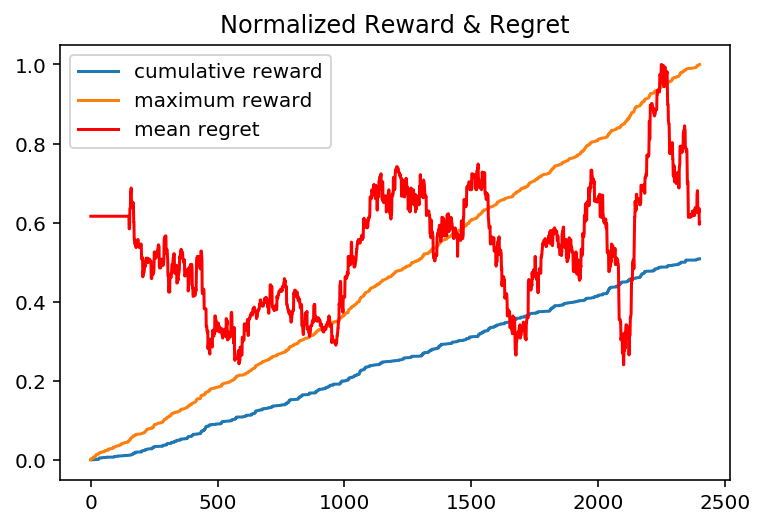

184.87962341308594
238.814697265625
165.00645446777344
210.94284057617188
177.68739318847656
163.50257873535156
195.596923828125
173.1473388671875
125.26203155517578
178.76084899902344
136.21401977539062
131.49139404296875
164.3534393310547
193.77191162109375
162.1510467529297
173.6201629638672
169.04885864257812
178.5277099609375
177.34487915039062
155.09938049316406
207.87313842773438
168.38888549804688
173.28994750976562
179.01644897460938
209.15989685058594
132.0560302734375
160.779296875
243.8074188232422
173.38351440429688
184.60311889648438
163.23971557617188
199.15541076660156
218.4869842529297
189.3275909423828
143.00868225097656
189.5707550048828
136.75973510742188
202.2310791015625
245.9425506591797
228.19573974609375
163.3502655029297
182.71182250976562
154.47918701171875
218.33106994628906
163.83392333984375
196.43833923339844
198.57896423339844
179.78297424316406
139.61842346191406
196.6902313232422
161.9390411376953
191.41107177734375
174.63865661621094
170.8884582519531

197.52244567871094
178.3074493408203
198.33807373046875
134.73583984375
182.4744415283203
208.88104248046875
200.8602294921875
188.65866088867188
161.6963348388672
164.21730041503906
166.36480712890625
179.1761932373047
196.541748046875
178.623291015625
188.67408752441406
165.20489501953125
128.6685028076172
208.5867462158203
192.47764587402344
222.76351928710938
159.95359802246094
159.4414825439453
193.79107666015625
182.23681640625
217.97723388671875
176.74282836914062
168.63568115234375
164.8991241455078
211.66302490234375
175.9476318359375
196.66363525390625
218.26907348632812
172.90509033203125
197.86819458007812
240.5148468017578
179.2350616455078
193.70521545410156
168.383056640625
182.56150817871094
193.0047607421875
186.52780151367188
192.6145477294922
213.68307495117188
213.709228515625
198.60545349121094
176.70860290527344
222.52713012695312
160.31727600097656
133.9812774658203
172.56187438964844
164.03627014160156
203.43833923339844
231.7853240966797
223.18423461914062
168.

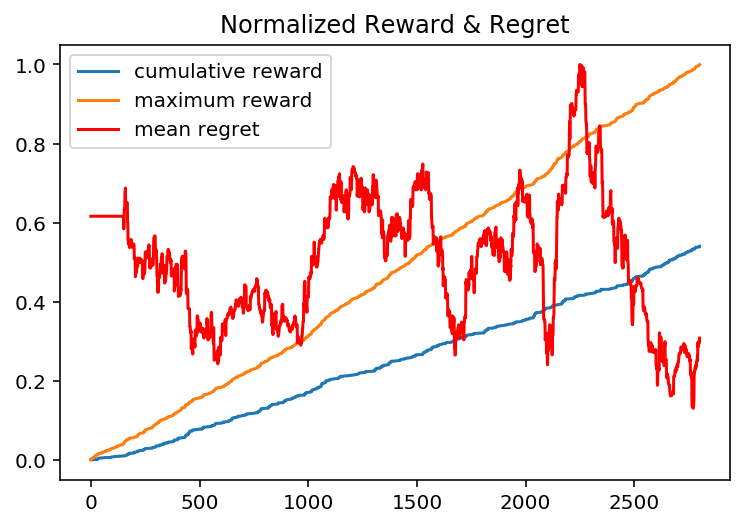

186.813232421875
217.83499145507812
195.3635711669922
167.64773559570312
172.10476684570312
197.88758850097656
179.4727783203125
225.3554229736328
199.85928344726562
155.62802124023438
210.55531311035156
173.06846618652344
163.67892456054688
181.54322814941406
199.57264709472656
125.29141998291016
235.8176727294922
178.57566833496094
176.86480712890625
203.26133728027344
175.42825317382812
184.5396270751953
259.544921875
168.72332763671875
202.62840270996094
194.2834014892578
192.87767028808594
170.1240997314453
180.2718505859375
217.81272888183594
192.86146545410156
210.709228515625
191.74935913085938
252.41748046875
226.1879119873047
158.79776000976562
209.82693481445312
194.0966339111328
230.15447998046875
184.01934814453125
227.62709045410156
208.4470977783203
229.63771057128906
219.4685821533203
178.38763427734375
218.03482055664062
208.44554138183594
212.3825225830078
146.78900146484375
219.92608642578125
178.7003936767578
177.3846435546875
246.86045837402344
186.7606964111328
17

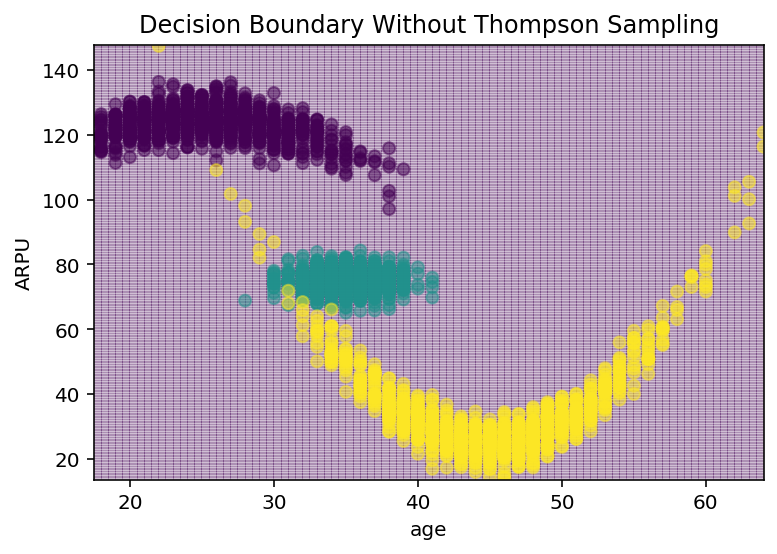

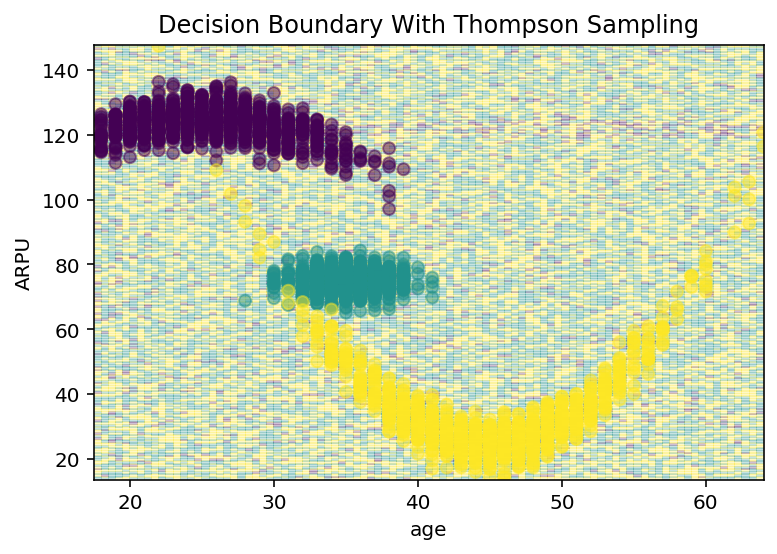

In [22]:
neural_model = NeuralBandits(num_actions, num_features, layer_sizes=[50,12], initial_pulls=100, verbose=False, initial_lr=.01)
records = iterate_model(neural_model, optimal_choices, 3000, plot_frequency=400)

plot_decision_boundary(neural_model, X, Y, h=.5, thompson=False, scale=1., title='Decision Boundary Without Thompson Sampling', flip_colors=False)
plot_decision_boundary(neural_model, X, Y, h=.5, thompson=True, scale=1., title='Decision Boundary With Thompson Sampling', flip_colors=False)

As we might expect, the neural model is more capable of learning nonlinear decision boundaries than the linear model.